last baseline, simple but with increased filters

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os 
import cv2
import imageio

data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/step1_png.zip

In [ ]:

def load(path):
    X = []
    Y = []
    labels = {
        0: 'CAM02',
        1: 'CAM01'}
    label = labels[0]
    for file in os.listdir(os.path.join(path, label)):
        image = cv2.imread(
            os.path.join(path, label, file),
            cv2.IMREAD_GRAYSCALE)
        
        image = image[218:1242,156:2204]

        image = image.astype('float32')/255.

        X.append(image)

    label = labels[1]
    for file in os.listdir(os.path.join(path, label)):
        image = cv2.imread(
            os.path.join(path, label, file),
            cv2.IMREAD_GRAYSCALE)
        
        image = image[218:1242,156:2204]

        image = image.astype('float32')/255.

        Y.append(image)

    return np.array(X), np.array(Y) #.astype('float32')

In [ ]:
# path
path = '/content/' 
#path='/content/step10_png'
# dati caricati
X, Y = load(path)

In [ ]:
X.shape , Y.shape

((200, 1024, 2048), (200, 1024, 2048))

In [ ]:
# fixing test set
a, test_corrupt, b, test_images = train_test_split(X,Y,test_size=6/200,shuffle=False, random_state=23)
a, val_corrupt, b, val_images = train_test_split(a,b,test_size=6/194,shuffle=False, random_state=23)
a, train_corrupt, b, train_images = train_test_split(a,b,test_size=160/188,shuffle=False, random_state=23)

In [ ]:
train_images.shape, train_corrupt.shape, val_images.shape, val_corrupt.shape

((160, 1024, 2048), (160, 1024, 2048), (20, 1024, 2048), (20, 1024, 2048))

X = train_corrupt
Y = train_images

A = val_corrupt
B = val_images

In [ ]:
train_corrupt = tf.reshape(train_corrupt, [-1,1024, 2048,1])   # qui serve -1 e 1 perche la rete vuole in input 4 canali?
val_corrupt = tf.reshape(val_corrupt, [-1,1024, 2048,1])
train_images = tf.reshape(train_images, [-1,1024, 2048,1])
val_images = tf.reshape(val_images, [-1,1024, 2048,1])
test_corrupt = tf.reshape(test_corrupt, [-1,1024, 2048,1])
test_images = tf.reshape(test_images, [-1,1024, 2048,1])

In [ ]:
# model of which we have results on tesi already

model = Sequential() # fit forward
model.add(InputLayer(input_shape=(1024, 2048,1))) 

model.add(Conv2D(8,(7,7), padding='same',activation='relu',data_format='channels_last'))
model.add(Conv2D(16,(3,3), padding='same',activation='relu',data_format='channels_last'))
#model.add(MaxPooling2D((2,2)))
model.add(Conv2D(2,(7,7), padding='same',activation='relu',data_format='channels_last'))
model.add(Conv2D(8,(5,5), padding='same',activation='relu',data_format='channels_last'))
#model.add(MaxPooling2D((2,2)))

#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,nesterov=True,name='SGD')  #dichiariamo l'ottimizzatore
model.compile(loss = tf.keras.losses.MeanSquaredError(),optimizer = 'adam', metrics = ['mae']) # addestriamo
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True) #serve per early stopping

history = model.fit(
    train_corrupt,
    train_images,
    epochs = 20,
    callbacks = [callback],
    batch_size =8,
    validation_data =(val_corrupt,val_images)
)

Epoch 1/20
20/20 [==============================] - 18s 759ms/step - loss: 0.2967 - mae: 0.4651 - val_loss: 0.1293 - val_mae: 0.2469
Epoch 2/20
20/20 [==============================] - 15s 747ms/step - loss: 0.1192 - mae: 0.2264 - val_loss: 0.1160 - val_mae: 0.2253
Epoch 3/20
20/20 [==============================] - 15s 752ms/step - loss: 0.0721 - mae: 0.1675 - val_loss: 0.0403 - val_mae: 0.1235
Epoch 4/20
20/20 [==============================] - 15s 750ms/step - loss: 0.0407 - mae: 0.1334 - val_loss: 0.0406 - val_mae: 0.1289
Epoch 5/20
20/20 [==============================] - 15s 749ms/step - loss: 0.0389 - mae: 0.1227 - val_loss: 0.0396 - val_mae: 0.1199
Epoch 6/20
20/20 [==============================] - 15s 748ms/step - loss: 0.0384 - mae: 0.1214 - val_loss: 0.0391 - val_mae: 0.1207
Epoch 7/20
20/20 [==============================] - 15s 749ms/step - loss: 0.0381 - mae: 0.1201 - val_loss: 0.0388 - val_mae: 0.1245
Epoch 8/20
20/20 [==============================] - 15s 752ms/step - 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1024, 2048, 8)     400       
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 2048, 16)    1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 1024, 2048, 2)     1570      
                                                                 
 conv2d_3 (Conv2D)           (None, 1024, 2048, 8)     408       
                                                                 
Total params: 3,546
Trainable params: 3,546
Non-trainable params: 0
_________________________________________________________________


model testing

In [ ]:
results = model.evaluate(test_corrupt,test_images)

1/1 [==============================] - 1s 550ms/step - loss: 0.0332 - mae: 0.1141


In [ ]:
predictions = model.predict(test_corrupt)

printing and comparing the images: predicted/blurred/original/differences:

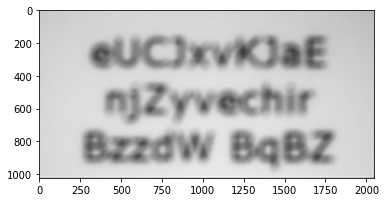

In [ ]:
pred = np.asarray(predictions)
uno = pred[4,:,:,0]
plt.imshow(uno,cmap='gray', vmin=0, vmax=1.)

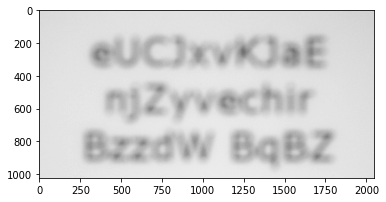

In [ ]:
uno_stripe = test_corrupt[4,:,:,0]
plt.imshow(uno_stripe,cmap='gray', vmin=0, vmax=1.)

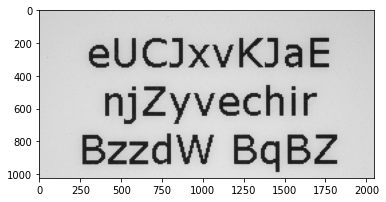

In [ ]:
uno_label = test_images[4,:,:,0]
plt.imshow(uno_label,cmap='gray', vmin=0, vmax=1.)

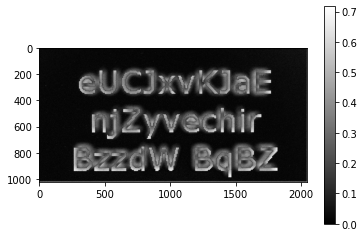

In [ ]:
diff=np.abs(uno_label-uno)
plt.imshow(diff,cmap='gray', vmin=0, vmax=np.max(diff))
plt.colorbar()

In [ ]:
np.max(diff)

0.7222505

summary of the model

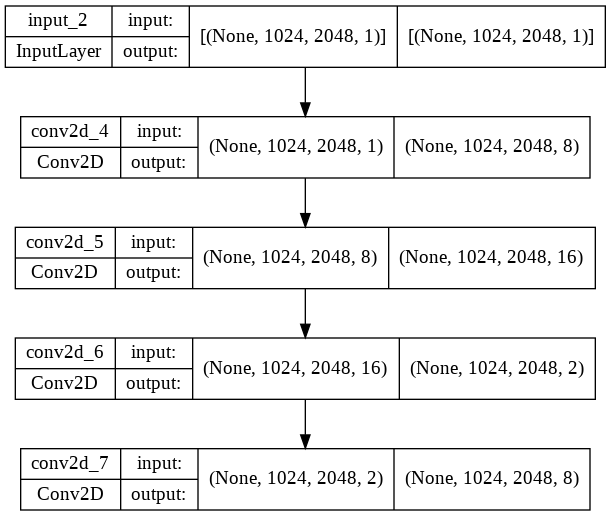

In [ ]:



tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

Stampiamo loss e performance sul train e validation:

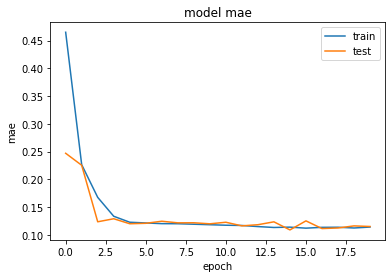

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

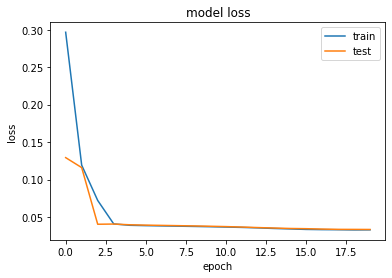

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()